Variables used in this notebook:

In [1]:
#PLAINTREE FILES NAMES
directory='/Users/julnow/gsi/cbm/ML/JupyterNotebooks/'
signalFileName = directory + 'PlainTree_20kSign.root'
backgroundFileName = directory + 'PlainTree_20kBckgr.root'

In [2]:
#CUTS FOR DATA CLEANING
#5 sigma region for signal
lower5SigmaCutSign = 0.43485
upper5SigmaCutSign = 0.56135
# "5sigma" (not acutal 5 sigma) region for background
lower5SigmaCutBckgr = 0.1
upper5SigmaCutBckgr = 2
#mass cuts for both bckgr and sign
lowerMassCut = 0.279
upperMassCut = 1.5
#distance cuts
#DCA
lowerDcaCut = 0
upperDcaCut = 100
#l distance
lowerLCut = 0
upperLCut = 80
#loverdl
lowerLdlCut = 0
upperLdlCut = 5000
#coordinate cuts
absXCut = 50
absYCut = 50
lowerZCut = 0
upperZCut = 50
#momentums cuts
pzLowerCut = 0
pUpperCut = 20
ptUpperCut = 3
#chi2
#geo
lowerChi2GeoCut = 0
upperChi2GeoCut = 1000
#topo
lowerChi2TopoCut = 0
upperChi2TopoCut = 100000
#prim first
lowerChi2PrimFirstCut = 0
upperChi2PrimFirstCut = 3e7
#prim second
lowerChi2PrimSecondCut = 0
upperChi2PrimSecondCut = 3e7
#pseudorapidity cuts
lowerEtaCut = 1
upperEtaCut = 6.5

# Importing the Libraries

**Numpy** is a powerful library that makes working with python more efficient, so we will import it and use it as np in the code. **Pandas** is another useful library that is built on numpy and has two great objects *series* and *dataframework*. Pandas works great for *data ingestion* and also has *data visualization* features. **Matplotlib** and **Seaborn** come handy in plotting and visualizing the data. From **Hipe4ml** we import **TreeHandler** and with the help of this function we will import our *Analysis Tree* to our notebook. We will also need some functions of **Scipy** for fittintg.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sn
#from hipe4ml.tree_handler import TreeHandler
#from hipe4ml import plot_utils
from matplotlib.patches import ConnectionPatch
from scipy.stats import binned_statistic as b_s
from scipy.stats import linregress
from sklearn import datasets, linear_model
import statsmodels.api as sm
import uproot
import gc
import os

In [4]:
#Shahid's library for importing roottrees
#%%capture
!git clone https://github.com/shahidzk1/CBM_ML_Lambda_Library.git
%cd CBM_ML_Lambda_Library
!git pull origin main
!pip install -r requirements.txt
!python setup.py install
from CBM_ML import tree_importer, plot_tools, KFPF_lambda_cuts

fatal: destination path 'CBM_ML_Lambda_Library' already exists and is not an empty directory.
/Users/julnow/gsi/cbm/ML/JupyterNotebooks/CBM_ML_Lambda_Library
hint: Pulling without specifying how to reconcile divergent branches is
hint: discouraged. You can squelch this message by running one of the following
hint: commands sometime before your next pull:
hint: 
hint:   git config pull.rebase false  # merge (the default strategy)
hint:   git config pull.rebase true   # rebase
hint:   git config pull.ff only       # fast-forward only
hint: 
hint: You can replace "git config" with "git config --global" to set a default
hint: preference for all repositories. You can also pass --rebase, --no-rebase,
hint: or --ff-only on the command line to override the configured default per
hint: invocation.
From https://github.com/shahidzk1/CBM_ML_Lambda_Library
 * branch            main       -> FETCH_HEAD
Already up to date.
running install
running bdist_egg
running egg_info
writing CBM_ML.egg-info/PKG

# Importing the data
CBM has a modified version of the cern's root software and it contains the simulated setup of CBM. Normally, a model generated input file, for example a URQMD 12 AGeV, is passed through different macros. These macros represent the CBM setup and it is like taking particles and passing them through a detector. These particles are registered as hits in the setup. Then particles' tracks are reconstructed from these hits using cellular automaton and Kalman Filter mathematics.


CBM uses the **TTree** format of cern root to store information. To reduce the size of these root files a modified tree file was created by the name of Analysis tree. This Analysis tree file contains most of the information that we need for physics analysis. 

A lambda baryon mostly decays into a proton and a pion. In this example, we download two files that were converted to a plain TTree format (simplest structure to be read by Python). The first one contains mostly background candidates for lambda i.e. protons and pions tracks which do not come from a lambda decay. The second file contains mostly signal candidates of lamba i.e. it contains protons and pions which come from a lambda decay.

The following lines of code converts the root files into a pandas dataframe objects. With the help of a selection cut, we select only signal candidates and background candidates from their respective data sets. Another selection cut chooses lambda candidates only in the $\pm 5\sigma$ region around the mean of the lambda mass peak. Similarly, we select the background candidates outside this $\pm 5\sigma$ region.

In [5]:
# We import three root files into our jupyter notebook
signal = tree_importer.tree_importer(signalFileName,'PlainTree',7)

# We only select lambda candidates in the 5 sigma region around the kaon mass peak
#we preserve the cleaned dataframe with a changed name
sign = signal[(signal['Candidates_generation']==1) & (signal['Candidates_mass']>lower5SigmaCutSign) & (signal['Candidates_mass']<upper5SigmaCutSign)]

# Similarly for the background, we select background candidates which are not in the 5 sigma region of the kaon peak
background = tree_importer.tree_importer(backgroundFileName,'PlainTree',7)
#we preserve the cleaned dataframe with a changed name
bckgr = background[(background['Candidates_generation'] < 1)
                & ((background['Candidates_mass'] > lower5SigmaCutBckgr)
                & (background['Candidates_mass'] < lower5SigmaCutSign) | (background['Candidates_mass']>upper5SigmaCutSign) 
                   & (background['Candidates_mass'] < upper5SigmaCutBckgr))]

#Also call the garbage collector of python to collect unused items to free memory
gc.collect()

2506

In [6]:
#we remove name prefixes 'Candidates'
bckgr.columns = bckgr.columns.str.replace('Candidates_', '')
bckgr.columns = bckgr.columns.str.replace('_', '')
sign.columns = sign.columns.str.replace('Candidates_', '')
sign.columns = sign.columns.str.replace('_', '')
#we also get rid of coordinates errors
sign = sign.drop(columns=['xerror', 'yerror', 'zerror', 'daughter1id', 'daughter2id', 'generation', 'pid', 'pTerr', 'etaerr', 'masserr', 'phierr'])
bckgr = bckgr.drop(columns=['xerror', 'yerror', 'zerror', 'daughter1id', 'daughter2id', 'generation', 'pid', 'pTerr', 'etaerr', 'masserr', 'phierr'])
#let's check the name prefixes 
sign

,chi2geo,chi2primfirst,chi2primsecond,chi2topo,cosinefirst,cosinesecond,cosinetopo,distance,eta,l,...,p,pT,phi,px,py,pz,rapidity,x,y,z
0,1.891688,1.962368e+06,3.017848e+06,0.938048,0.990561,0.924455,1.000000,0.013951,2.486938,7.397236,...,1.630809,0.269387,-1.558258,0.003378,-0.269366,1.608406,1.766340,-0.051667,-1.166708,7.296682
1,7.539669,3.927906e+03,2.038832e+05,103.285400,0.985466,0.928299,0.998588,0.022819,2.094620,1.386346,...,1.539342,0.373378,0.968337,0.211583,0.307643,1.493373,1.604629,0.376725,0.412234,1.773447
2,1.706541,7.728520e+03,4.239785e+02,0.606264,0.955050,0.999384,1.000000,0.030017,2.734314,1.283027,...,2.256752,0.291869,-1.159367,0.116724,-0.267513,2.237798,2.062438,0.119157,-0.202402,1.272765
4,2.070187,2.158610e+07,4.508973e+06,1.449760,0.976016,0.987120,0.999998,0.003052,2.068460,10.053052,...,2.097096,0.521730,-1.788829,-0.112855,-0.509378,2.031160,1.767285,-0.482202,-2.512969,9.732567
5,0.537335,1.793734e+05,1.617219e+05,3.097740,0.987572,0.995492,0.999998,0.029134,3.090779,32.053776,...,3.330041,0.302186,2.902284,-0.293574,0.071627,3.316302,2.436012,-2.803859,0.580953,31.920332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18548,0.828542,1.215828e+05,3.289300e+03,2.874015,0.985290,0.999682,0.999999,0.006490,2.796818,2.829402,...,4.195267,0.509959,2.025228,-0.223847,0.458204,4.164157,2.465164,-0.092417,0.049271,2.808812
18549,0.596789,3.996718e+05,4.578449e+03,0.210822,0.905545,0.996238,1.000000,0.011491,2.073165,2.137405,...,1.737286,0.430248,-1.548416,0.009628,-0.430141,1.683166,1.663028,0.072870,-0.791343,2.071759
18550,0.914715,1.424299e+02,1.249055e+03,1.045869,0.996485,0.886797,0.999848,0.033572,2.259869,0.368948,...,1.575304,0.325267,3.080482,-0.324660,0.019865,1.541358,1.681794,-0.047360,0.044470,0.363255
18551,0.625351,3.890271e+03,4.369722e+06,5.880854,0.964153,0.964963,0.999712,0.217372,2.084068,10.454948,...,1.458295,0.357359,2.195039,-0.208870,0.289963,1.413832,1.588644,-1.226871,2.153837,10.165808


Before data cleaning we'll look at all distributions

<ipython-input-7-086be5102928>:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,7))


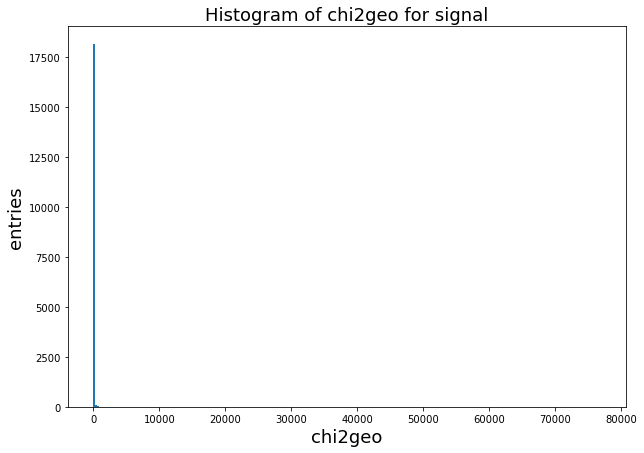

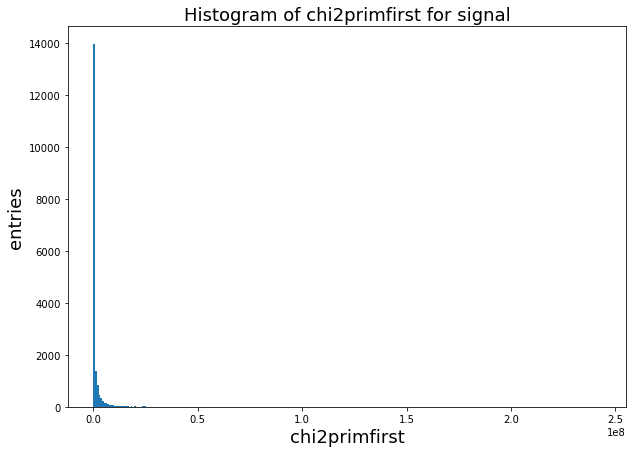

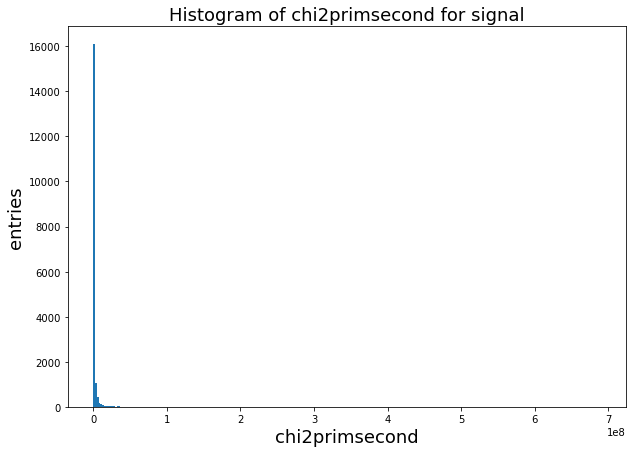

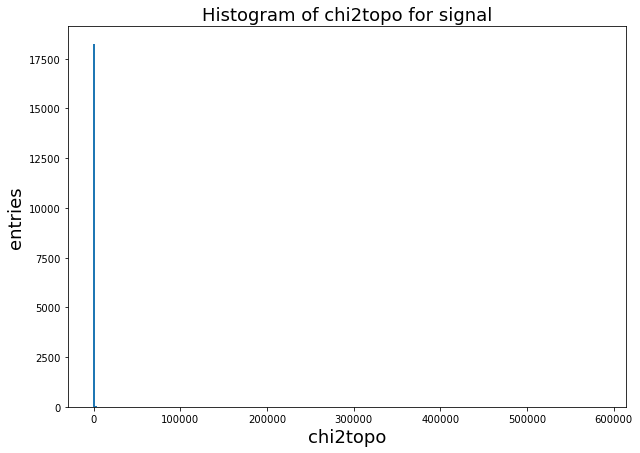

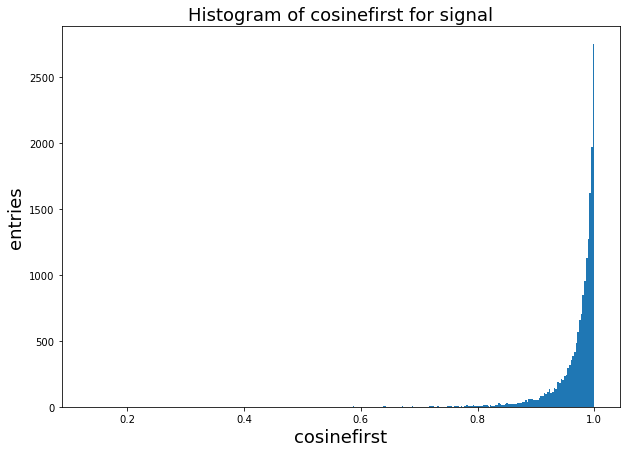

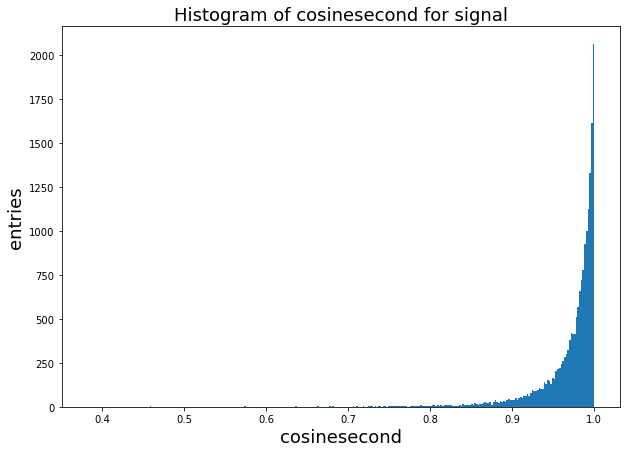

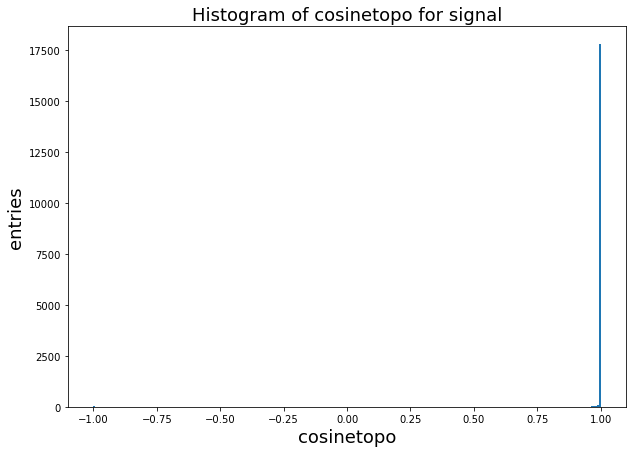

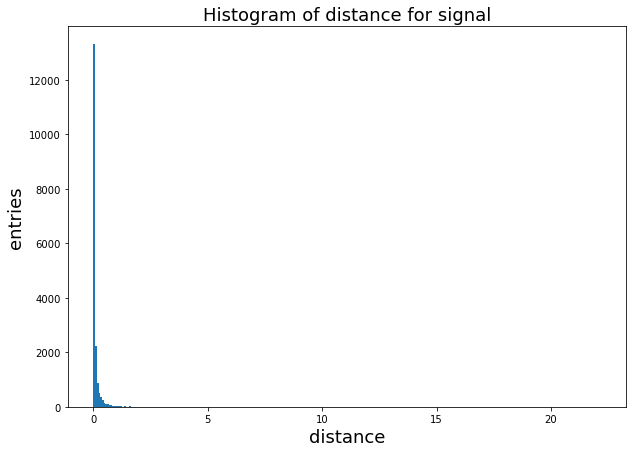

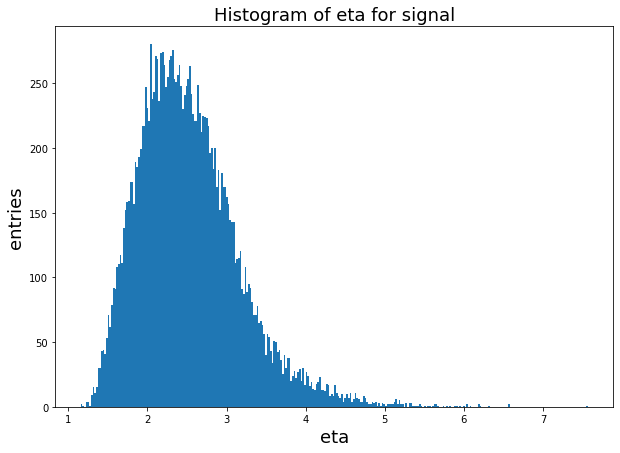

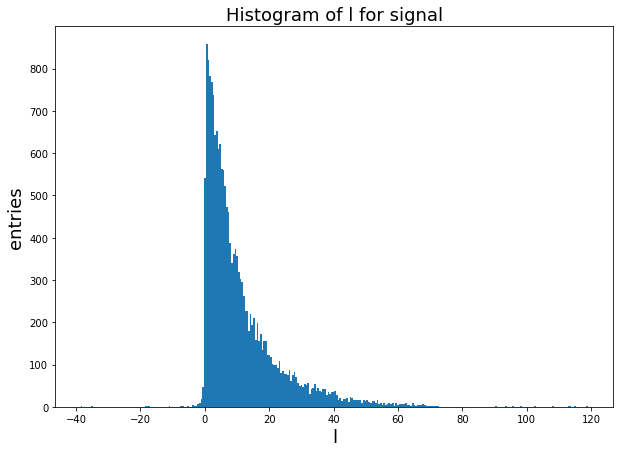

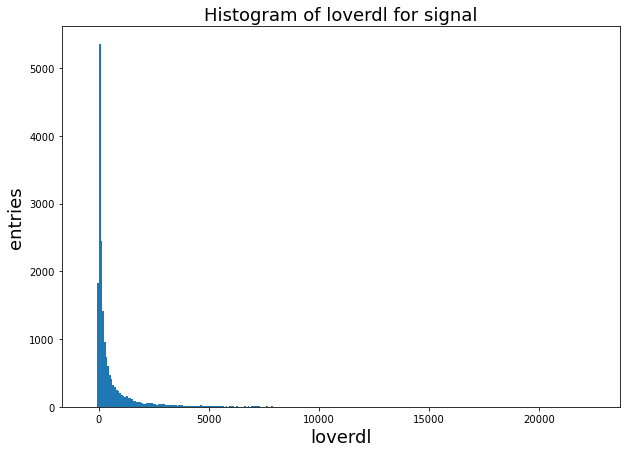

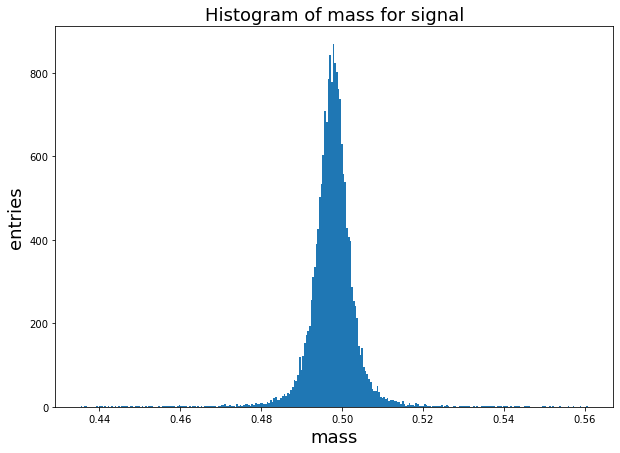

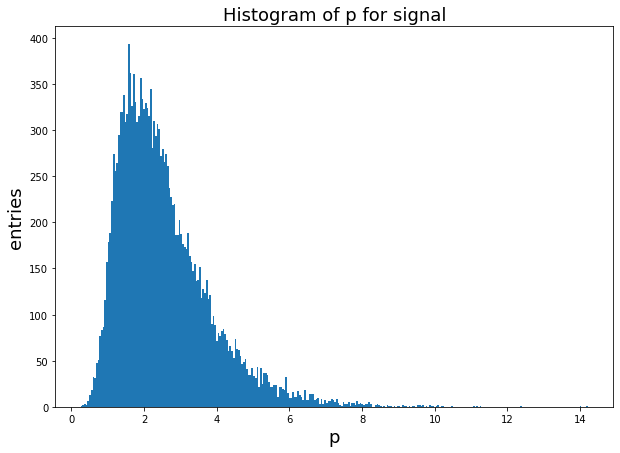

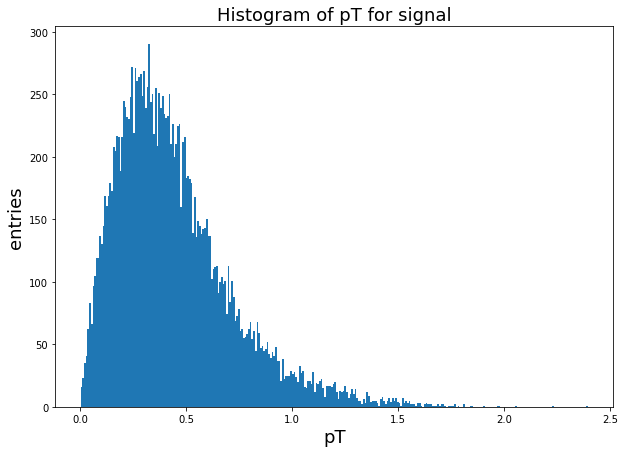

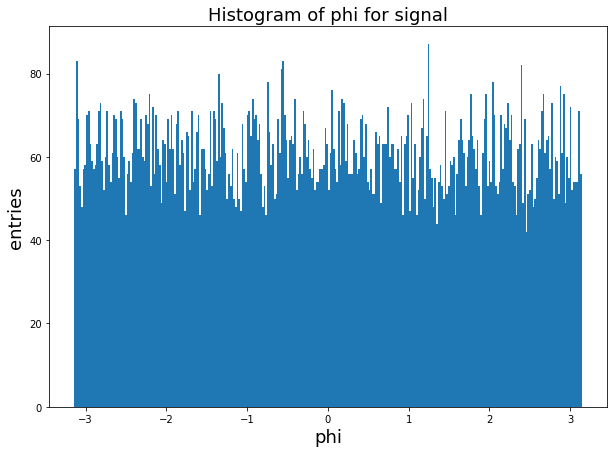

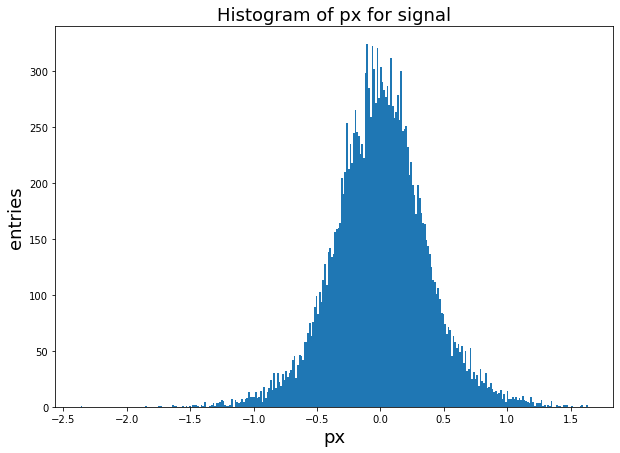

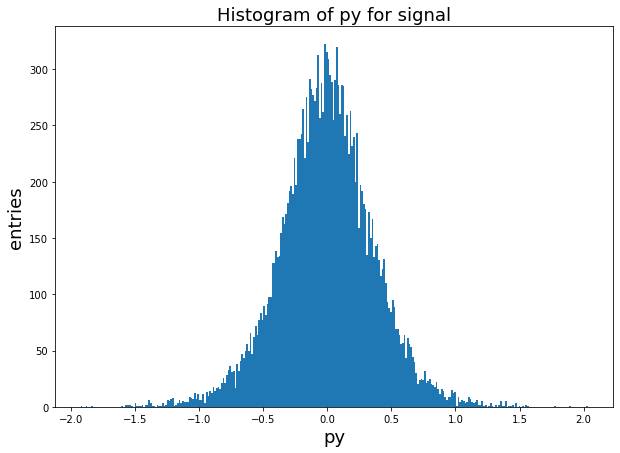

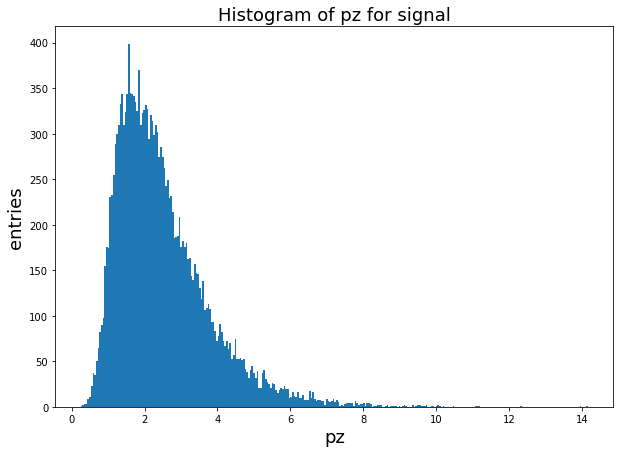

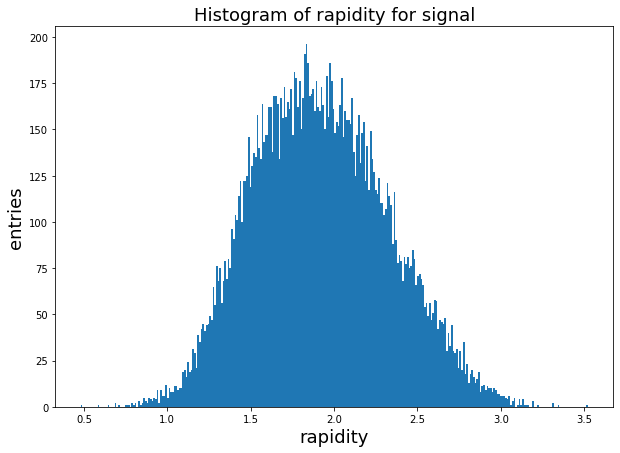

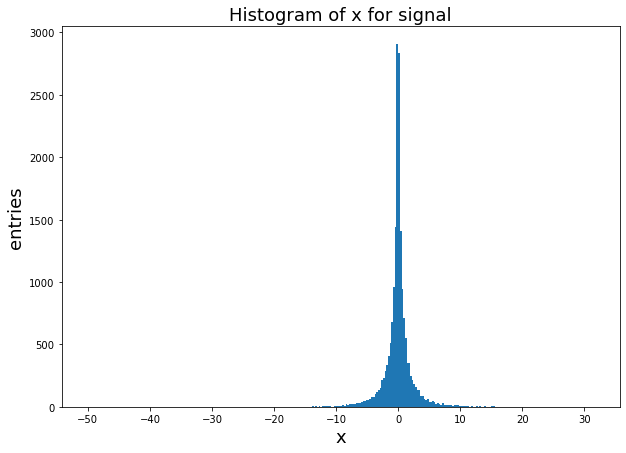

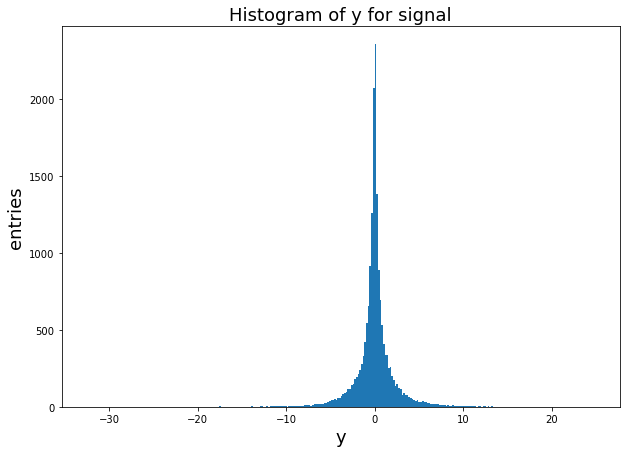

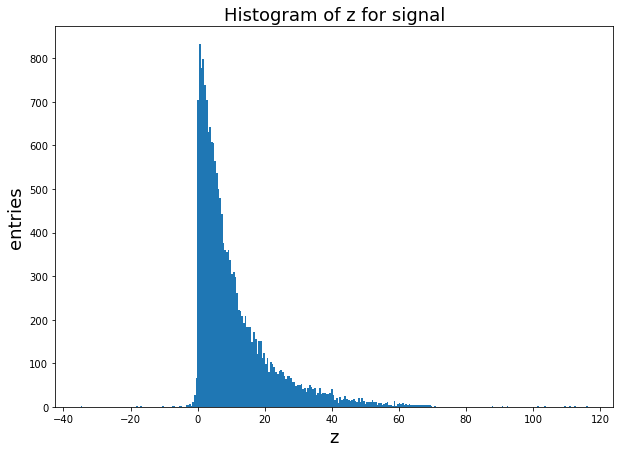

In [7]:
if not os.path.exists(directory+'signal'):
    os.makedirs(directory+'signal')
for i in sign.columns:
    fig, ax = plt.subplots(figsize=(10,7))
    name = sign[i].name
    plt.title('Histogram of ' + name + ' for signal', fontsize=18)
    plt.xlabel(name, fontsize=18)
    plt.ylabel("entries", fontsize=18)
    plt.hist(sign[i], bins=300)
    fig.savefig(directory+"signal/"+ name + ".png")

ValueError: supplied range of [-5.0273661613464355, inf] is not finite

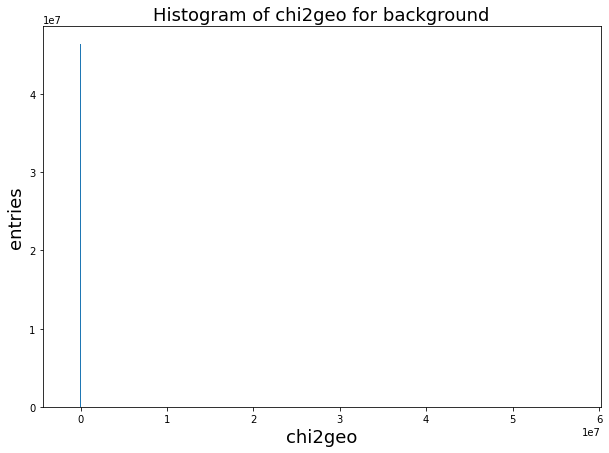

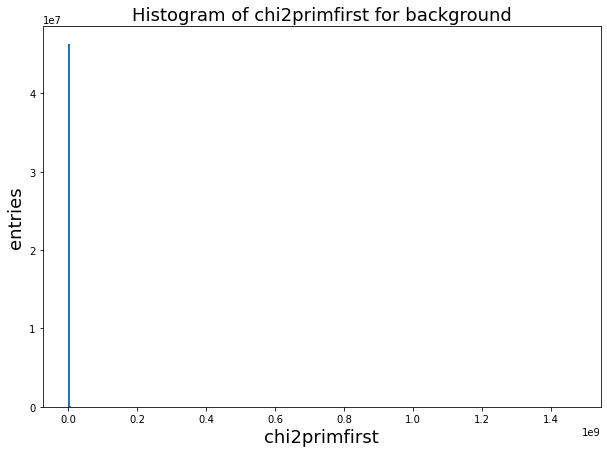

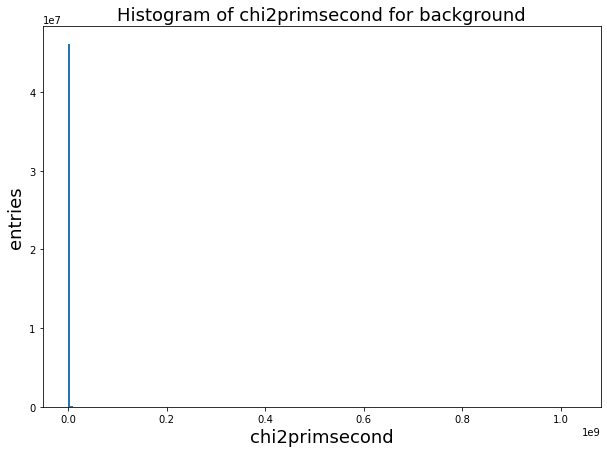

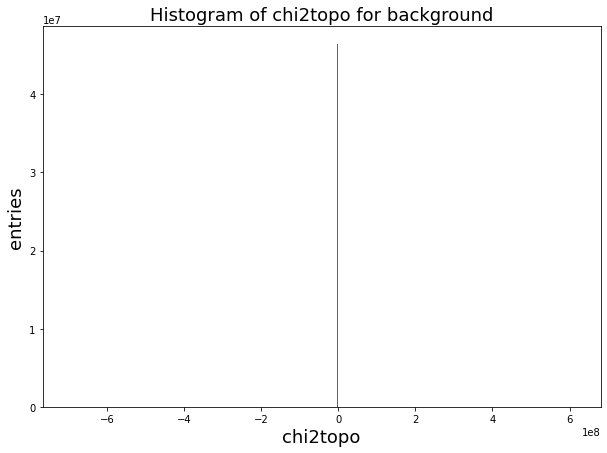

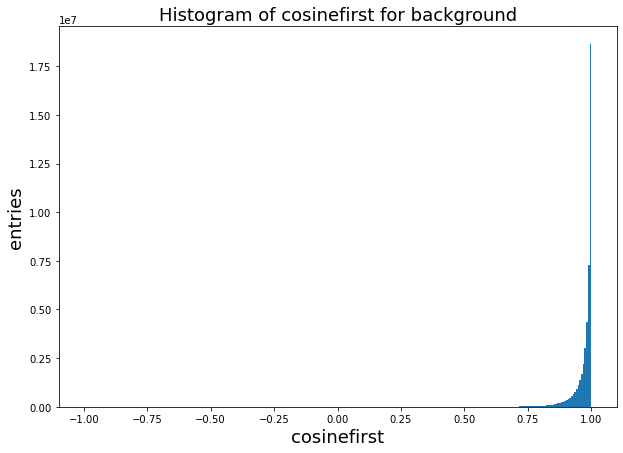

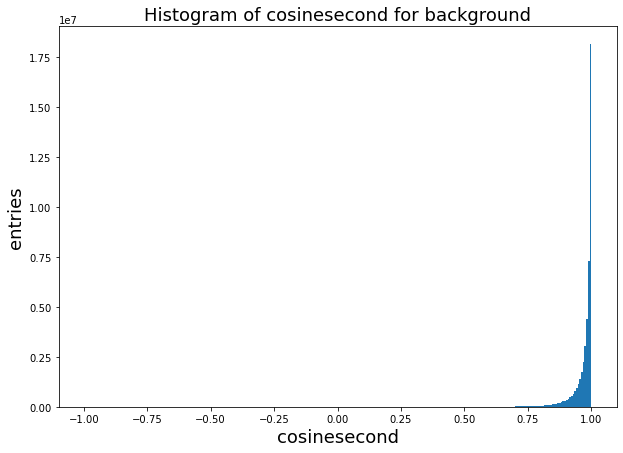

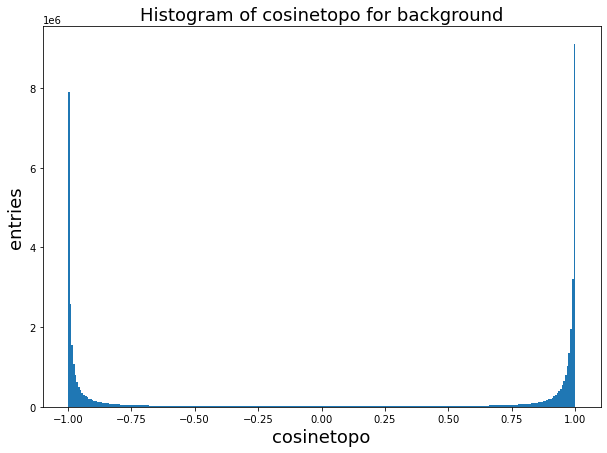

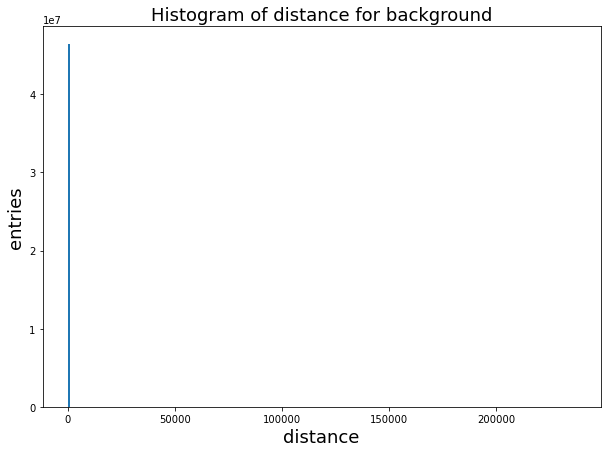

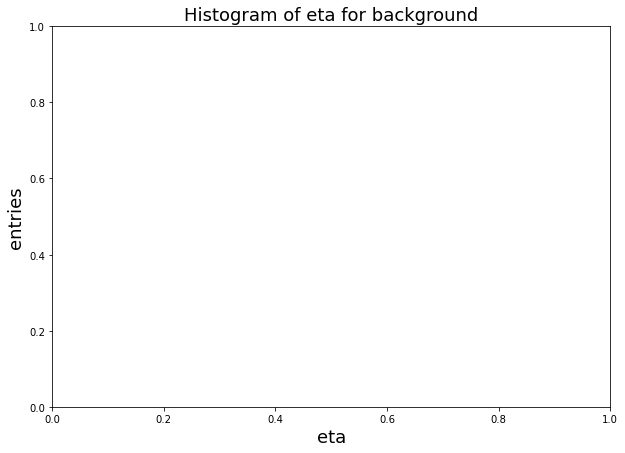

In [8]:
if not os.path.exists(directory+'background'):
    os.makedirs(directory+'background')
for i in bckgr.columns:
    fig, ax = plt.subplots(figsize=(10,7))
    name = bckgr[i].name
    plt.title('Histogram of ' + name + ' for background', fontsize=18)
    plt.xlabel(name, fontsize=18)
    plt.ylabel("entries", fontsize=18)
    plt.hist(bckgr[i], bins=300)
    fig.savefig(directory+"background/"+ name + ".png")

# Data Cleaning
Sometimes a data set contains entries which are outliers or does not make sense. For example, infinite values or NaN entries. We clean the data by removing these entries. 

Similarly, CBM is a fixed target experiment so there are certain conditions which the data has to satisfy before it is considered as reliable data.So we apply certain limits on the data sets.

Ofcourse, we lose some data points but these outliers sometimes cause problems when we perform analysis. 

In [9]:
def clean_df(df):
    # let's treat all the infinite, inf, values by nan and then we drop all the null entries
    with pd.option_context('mode.use_inf_as_na', True):
        df = df.dropna()
    #Experimental constraints
    is_good_mom = (df['pz'] > pzLowerCut) & (df['p']<pUpperCut) & (df['pT']<ptUpperCut)
    is_good_coord = (abs(df['x']) < absXCut) & (abs(df['y']) < absYCut) & (df['z']>lowerZCut) & (df['z']<upperZCut)
    is_good_params = (df['distance'] > lowerDcaCut) & (df['distance'] < upperDcaCut) & (df['chi2geo']>lowerChi2GeoCut) & (df['chi2geo'] < upperChi2GeoCut) & (df['chi2topo'] > lowerChi2TopoCut) & (df['chi2topo'] < upperChi2TopoCut) & (df['eta']>lowerEtaCut) & (df['eta']<upperEtaCut)& (df['l']>lowerLCut) & (df['l']<upperLCut) & (df['loverdl']>lowerLdlCut) & (df['loverdl']<upperLdlCut)
    is_good_daughters = (df['chi2primfirst']>lowerChi2PrimFirstCut) & (df['chi2primfirst'] < upperChi2PrimSecondCut) & (df['chi2primsecond']>lowerChi2PrimSecondCut) & (df['chi2primsecond']<upperChi2PrimFirstCut)
    is_good_mass = (df['mass']>lowerMassCut) & (df['mass']<upperMassCut)

    is_good_df = (is_good_mom) & (is_good_coord) & (is_good_params) & (is_good_daughters) & (is_good_mass)

    return df[is_good_df]

In [10]:
#we'll count how much data we loose
bckgrCount = len(bckgr)
signCount = len(sign)
#we return to normal names while cleaning data
background = clean_df(bckgr)
signal = clean_df(sign)
backgroundCount = len(background)
signalCount = len(signal)
#lets count how much data we lose
backgroundDifference = bckgrCount-backgroundCount
signalDifference = signCount-signalCount
percentageBg = backgroundDifference/bckgrCount*100
percentageSg = signalDifference/signCount*100
#finally
print('we lost ' + str(backgroundDifference)+' background entries (' + str(round(percentageBg, 2)) + '%) and ' + str(signalDifference) + ' signal entries (' + str(round(percentageSg)) + '%)')

we lost 24267217 background entries (52.31%) and 974 signal entries (5%)


# Correlation
We find the correlation of all variables with signal and background candidates. We use the pearson correlation coefficient (linear correlation) for our analysis. It is defined as 
$$
\rho = \frac{COV(X,Y)}{\sigma_X \times \sigma_Y}
$$
Here, COV(X,Y) is the covariance of the variable X and Y, and $\sigma_X$ and $\sigma_Y$ are the standard deviations of the variables. Pearson co-efficient is useful for linear correlation but it fails to take into account outliers and non-linear correlation. $\rho \> 0$ means postive while the opposite means negative correlation between two variables. 

This correlation function comes in built in the pandas library so we are using it. This function can also find other non-linear correlation coefficients like kendall and spearman. 

In [11]:
variables_to_draw = ['chi2geo', 'chi2primfirst', 'chi2primsecond', 'chi2topo', 'cosinefirst',
       'cosinesecond', 'cosinetopo', 'distance', 'eta', 'l', 'loverdl',
       'mass', 'p', 'pT', 'phi', 'px', 'py', 'pz', 'rapidity']

In [12]:
def correlation_graph(df, variables, title):
    # The variables pid, isfrompv and issignal are not that much varying so we remove them
    new_df = df[variables]
    # Using the pandas correlation function corr we find the correlation
    df_correlation_all = new_df.corr(method='pearson')
    
    #The cosmetics of the graph
    fig, ax = plt.subplots(figsize=(20,15))  #figure size
    cmap = sn.diverging_palette(240, 10, as_cmap=True, n=200) #color map
    cax = sn.heatmap(df_correlation_all, annot=True,cbar_kws={"shrink": .5},  cmap=cmap,  vmin=-1, vmax=1, 
                 center=0)
    ax.set_xticks(np.arange(0, len(df_correlation_all.columns), step=1))
    ax.set_xticklabels(df_correlation_all.columns, fontsize=15, rotation =70)
    ax.set_yticklabels(df_correlation_all.columns, fontsize=15)
    ax.set_title(title, fontsize = 20)
    fig.tight_layout()
    fig.savefig(title+'.png')

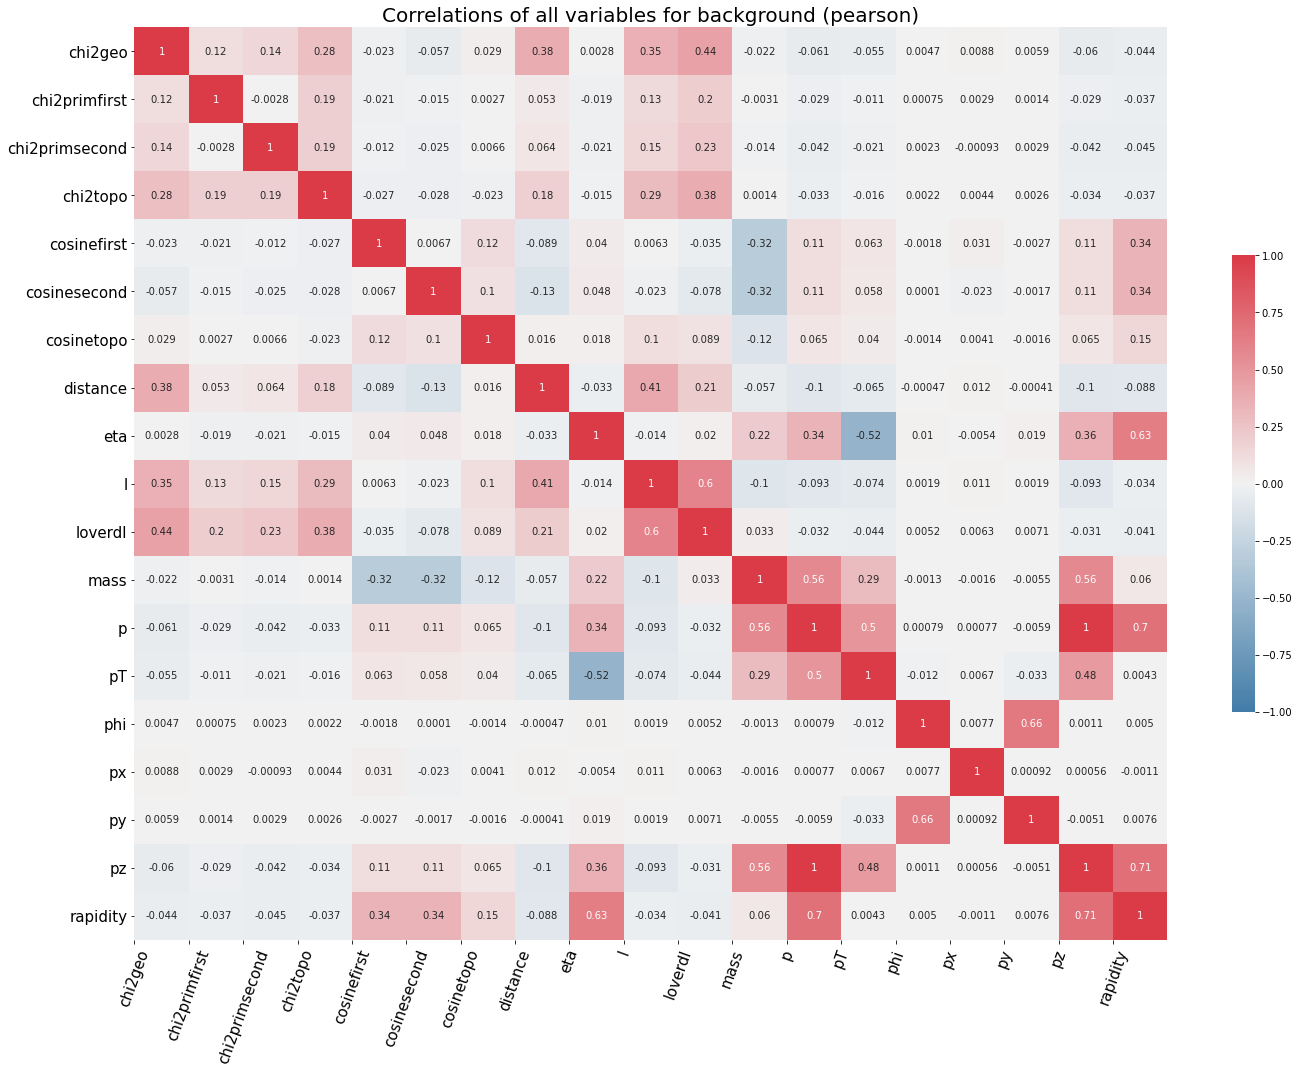

In [13]:
#correlation graph for background
correlation_graph(background, variables_to_draw, 'Correlations of all variables for background (pearson)')

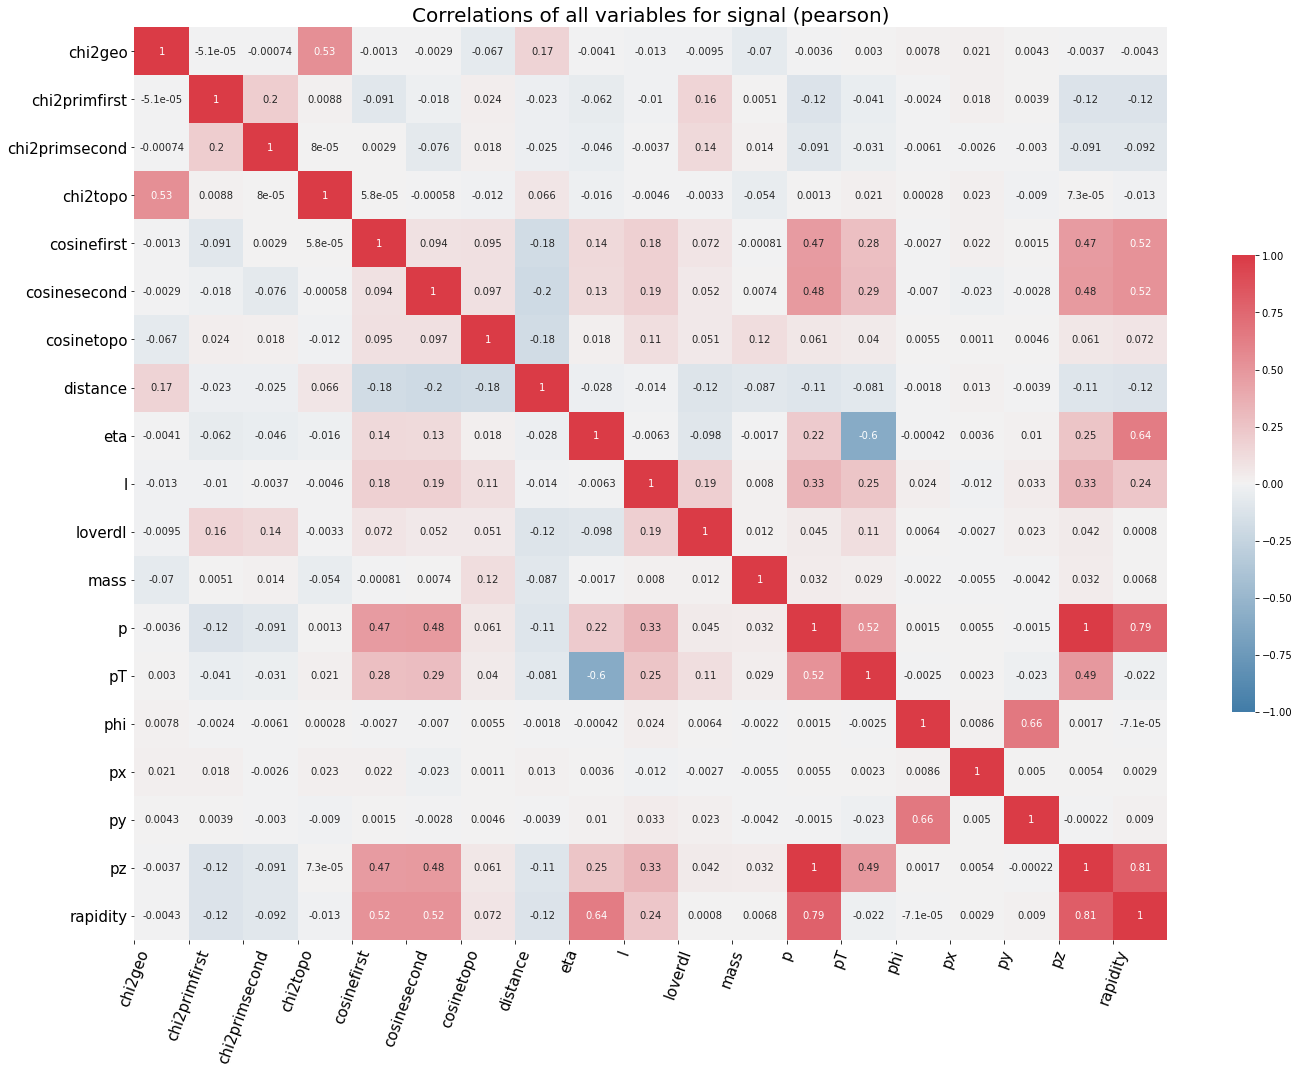

In [14]:
#correlation graph for signal
correlation_graph(sign, variables_to_draw, 'Correlations of all variables for signal (pearson)')

The correlation graph of the background variables shows that cosinepos is correlated with mass. To check whether it is a real correlation or a statistical fluctuation we make our own correlation function. 

## Correlations by formula
The following function calculates the correlation along with the standard error of the mean (SEM) of the input variable with all the other variables. The standard error of the mean is defined as $ SEM = \frac{\sigma}{\sqrt{n}}$. Here $\sigma$ is the standard deviation of a variable. It will put error bars on each bin.

The function accepts 3 variables, a data frame object in the first input, a list of strings to be correlated with the third input (a string).

In [15]:
def calculate_correlation(df, vars_to_corr, target_var) :
    
    from scipy.stats import sem

    mean = df[target_var].mean()
    sigma = df[target_var].std()

    correlation = []
    error = []
    
    for j in vars_to_corr : 
        mean_j = df[j].mean()
        sigma_j = df[j].std()
        
        cov = (df[j] - mean_j) * (df[target_var] - mean) / (sigma*sigma_j)        
        correlation.append(cov.mean())
        error.append(sem(cov))
    
    return correlation, error

In [16]:
# Provide the data frame object first, then also inside the brackets of list and then write the variable inside inverted commas ''.
# For signal
corr_signal, corr_signal_errors = calculate_correlation(signal, list(signal), 'mass')
# For background
corr_bg, corr_bg_errors = calculate_correlation(background, list(background), 'mass')

<ipython-input-17-7ff6f05e38c6>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(signal.columns, fontsize=15, rotation =90)


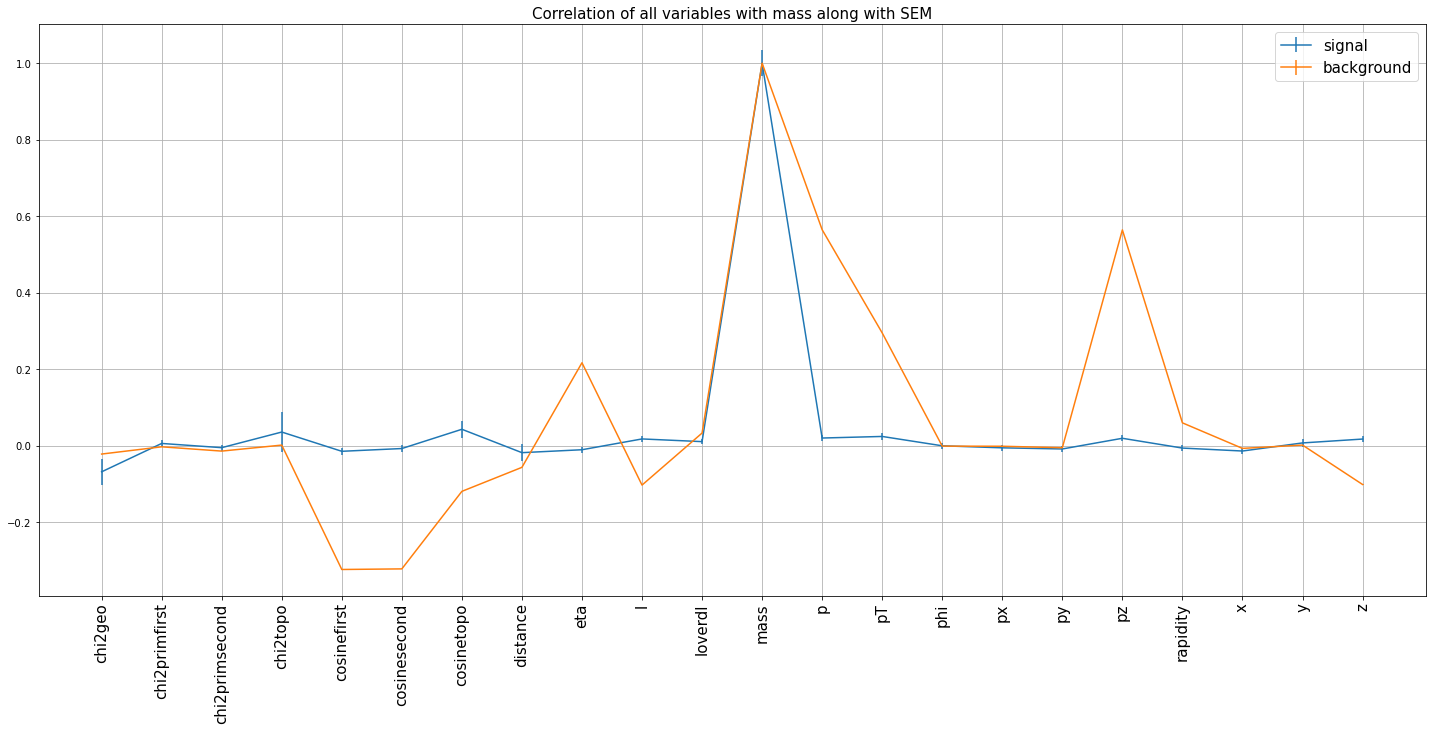

In [17]:
# Plotting the correlations of various variables with mass along with the errors
fig, ax = plt.subplots(figsize=(20,10))
plt.errorbar(list(signal), corr_signal, yerr=corr_signal_errors, fmt='')
plt.errorbar(list(background), corr_bg, yerr=corr_bg_errors, fmt='')
ax.grid(zorder=0)
ax.set_xticklabels(signal.columns, fontsize=15, rotation =90)
plt.legend(('signal','background'), fontsize = 15)
fig.tight_layout()
plt.title('Correlation of all variables with mass along with SEM', fontsize = 15)
fig.savefig("Correlation of all variables with mass along with SEM.png")

## Scatter plot between variables
To analyze the correlation between the mass variable and the cosine of the angle between the proton and the lambda for the background set, we multi-differential analysis.

We make a function which takes in a data frame object in the first input, and then two variables from this df in the next inputs. This function takes the entries of the variables and distributes them in 100 bins. The function then plots the bin centers of the first variable on the x-axis and the mean values of the bins of the second variable on the y-axis, along with its bin stds.

In [18]:
#for variable bin size, use the following bins
non_uniform_binning = [1.07032418, 1.07962069, 1.08891719, 1.0982137 , 1.1075102 ,
       1.11680671, 1.12610322, 1.13539972, 1.14469623, 1.15399273,
       1.16328924, 1.17258574, 1.18188225, 1.19,1.20977176, 1.25625429,
       1.30273682, 1.34921935, 1.39570187, 1.4421844 , 1.48866693,
       1.53514946, 1.58163198, 1.62811451, 1.67459704, 1.72107956,
       1.76756209, 1.81404462, 1.86052715, 1.90700967, 1.9534922 ,
       1.99997473]
bb = ['1.07', '', '', '', '1.1', '', '', '1.13', '', '', '', '', '', '', '1.2', '1.25', '1.3', '1.34', '1.39', '1.44', '1.48', '1.53', '1.58', '1.62', '1.67', '1.72', '1.76', '1.814', '1.86', '1.9', '1.953', '1.99']

In [19]:
#for variable bin size, use the following bins
uniform_binning = 100

In [20]:
def profile_plot(df,variable_xaxis,variable_yaxis, binning):
    fig, axs = plt.subplots(figsize=(20, 15))
    # Distributing the data into 100 bins
    bin_means, bin_edges, binnumber = b_s(df[variable_xaxis],df[variable_yaxis], statistic='mean', bins=binning)
    bin_std, bin_edges, binnumber = b_s(df[variable_xaxis],df[variable_yaxis], statistic='std', bins=binning)
    bin_count, bin_edges, binnumber = b_s(df[variable_xaxis],df[variable_yaxis], statistic='count', bins=binning)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    plt.errorbar(x=bin_centers, y=bin_means, yerr=(bin_std/np.sqrt(bin_count)), linestyle='none', marker='.',mfc='red', ms=10)
    # Fitting a line on the data  
    X = bin_centers
    y = bin_means
    X2 = sm.add_constant(X) 
    est = sm.OLS(y, X2)
    est2 = est.fit()
    p_value1=str(est2.pvalues[0])
    p_value2=str(est2.pvalues[1])
    slope, intercept, r_value, p_value, std_err = linregress(x=bin_centers, y=bin_means)
    print("summary()\n",est2.summary())
    print("pvalues\n",est2.pvalues)
    print("tvalues\n",est2.tvalues)
    print("rsquared\n",est2.rsquared)
    print("rsquared_adj\n",est2.rsquared_adj)
    print('sum of squared residuals = ', np.sum(est2.resid))
    
    from sklearn.metrics import mean_squared_error
    print('mean squared error: ',mean_squared_error(bin_means, intercept + slope*bin_centers))

    predictions = est2.predict(X2)

    print(est2.predict(X2[:3,:]))

    #plt.vlines(x=1.115,ymin=0.96,ymax=1.01, color='r', linestyle='-')
  
    #plotting
    plt.plot(bin_centers, intercept + slope*bin_centers, 'b', label='fitted line'+
             " with $R^2$-squared: %f" % r_value**2+'\n and the p values are \n ['+p_value1+'  '+ p_value2+'] \n $\chi^2$')
    plt.legend(fontsize=15)
    title='Mean of ' +variable_yaxis+ ' plotted versus bin centers of '+variable_xaxis
    plt.title(title, fontsize=18)
    plt.xlabel("Bin centers", fontsize=18)
    plt.ylabel("Mean of each bin with the SEM ($\dfrac{bin\ std}{\sqrt{bin\ count}}$) of bin", fontsize=18)
    #for non-uniform binning labels
    #axs.set_xticks(non_uniform_binning)
    #axs.set_xticklabels(bb)
    axs.tick_params(labelsize=18)
    fig.tight_layout()
    fig.savefig(title+'.png')

In [21]:
def two_D_hist(var_xaxis, var_yaxis):
    import matplotlib as mpl
    fig, axs = plt.subplots(figsize=(15, 10))
    plt.hist2d(var_xaxis,var_yaxis, bins=100, norm=mpl.colors.LogNorm())
    plt.xlabel(var_xaxis.name, fontsize=15)
    plt.ylabel(var_yaxis.name, fontsize=15)
    title="2D histogram having "+var_xaxis.name +" on the x-axis and "+var_yaxis.name+" on the y-axis"
    plt.title(title, fontsize=15)
    axs.tick_params(labelsize=18)
    fig.tight_layout()
    fig.savefig(title+'.png')

Correlations for eta

summary()
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.733
Method:                 Least Squares   F-statistic:                     272.9
Date:                Wed, 04 Aug 2021   Prob (F-statistic):           4.44e-30
Time:                        16:59:33   Log-Likelihood:                 175.51
No. Observations:                 100   AIC:                            -347.0
Df Residuals:                      98   BIC:                            -341.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3966      0.011     36.5

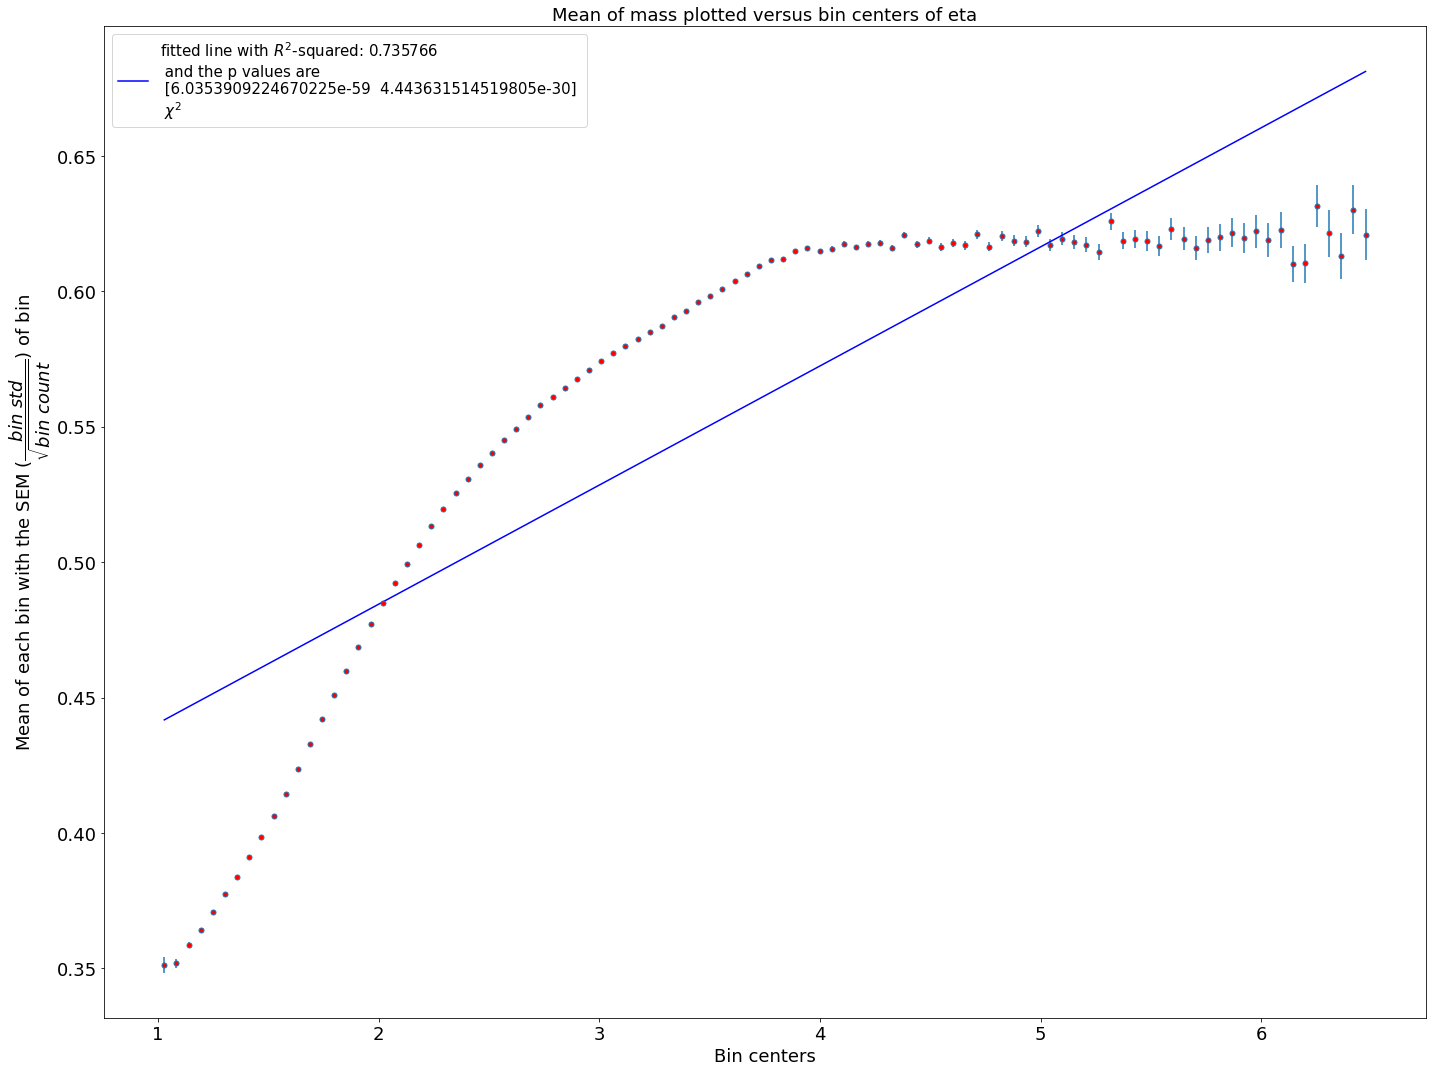

In [22]:
profile_plot(background,'eta','mass',uniform_binning)

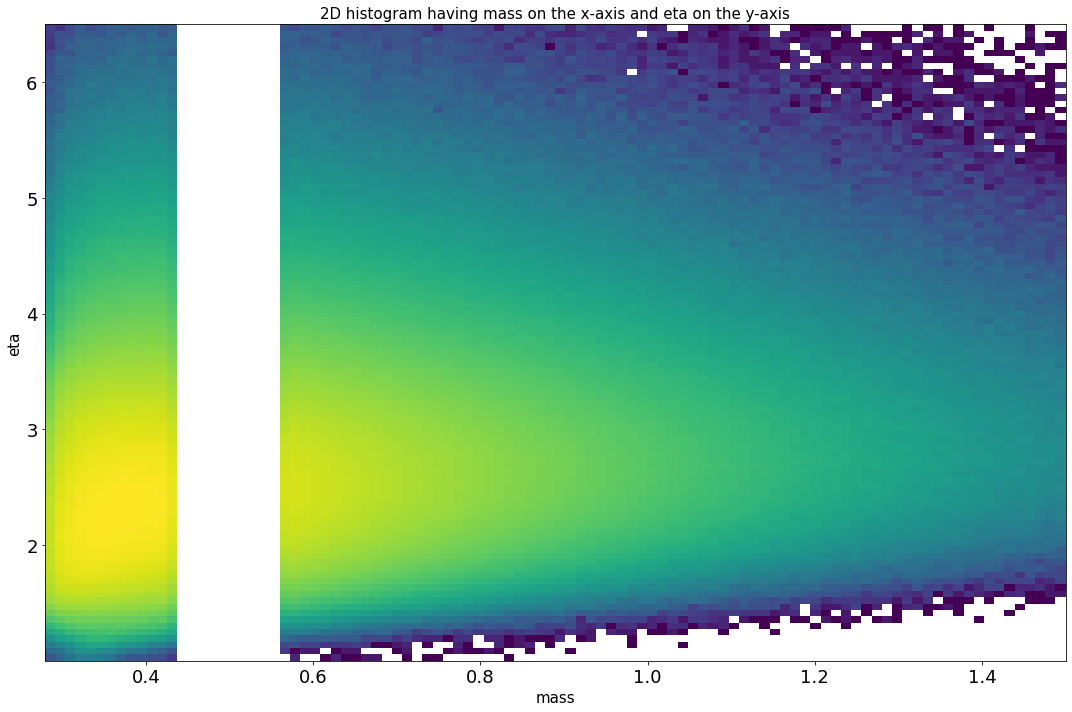

In [23]:
two_D_hist(background['mass'], background['eta'])

Correlations for p

summary()
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     260.4
Date:                Wed, 04 Aug 2021   Prob (F-statistic):           2.38e-29
Time:                        16:59:49   Log-Likelihood:                 85.528
No. Observations:                 100   AIC:                            -167.1
Df Residuals:                      98   BIC:                            -161.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5253      0.021     25.0

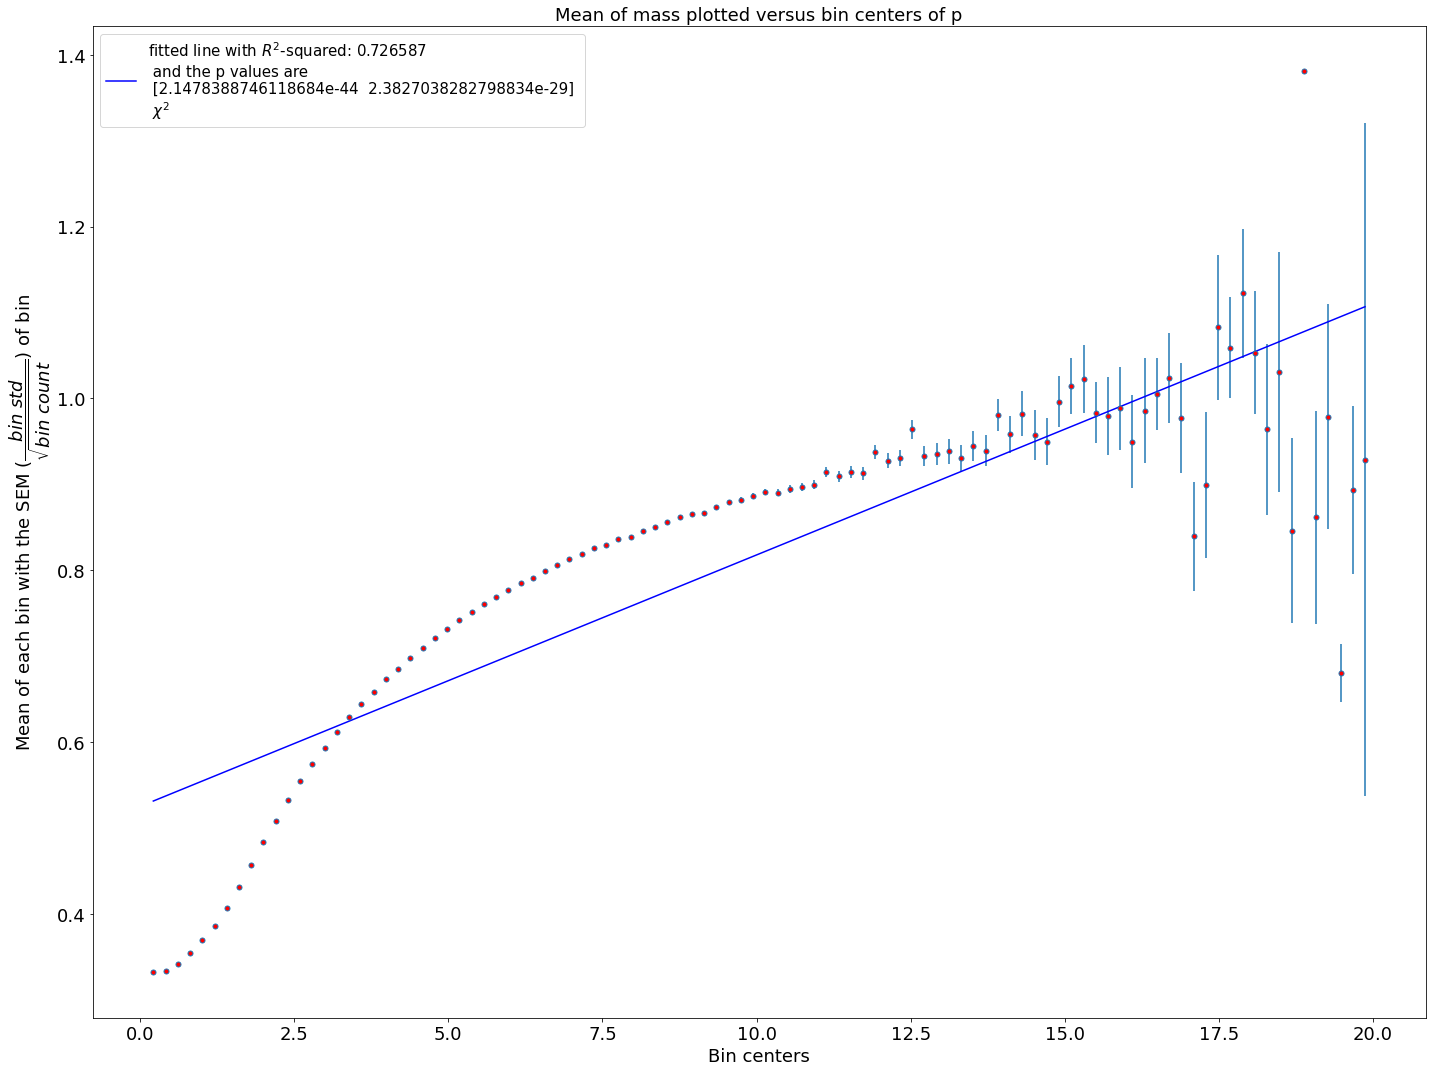

In [24]:
profile_plot(background,'p','mass',uniform_binning)

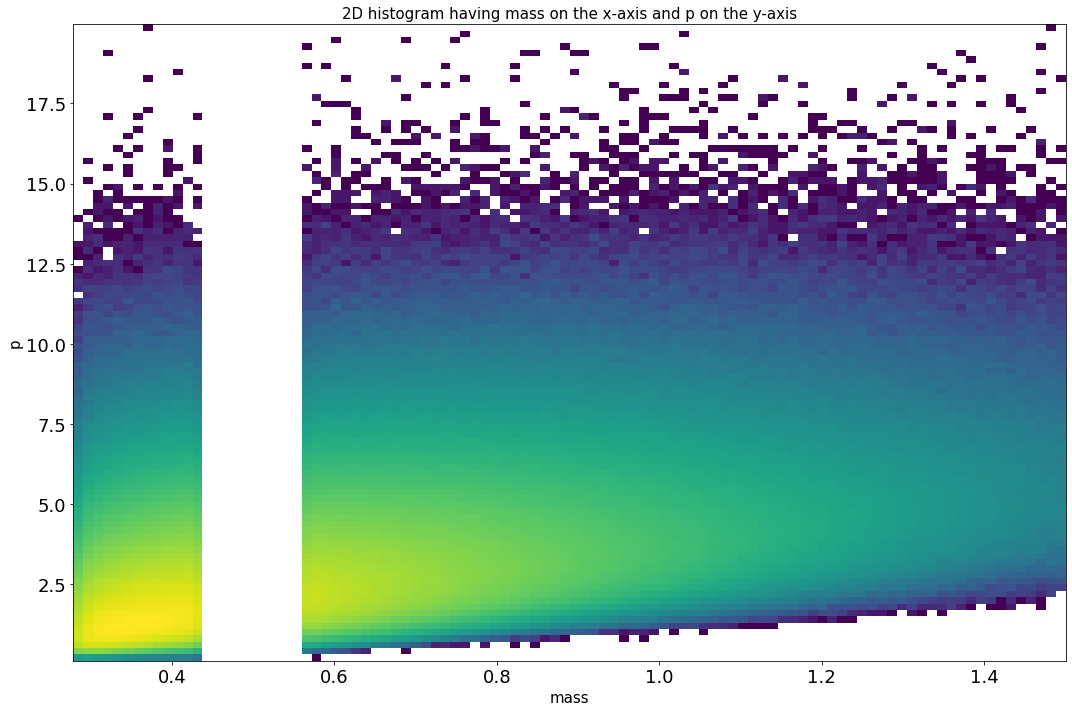

In [25]:
two_D_hist(background['mass'], background['p'])

Correlations for pZ

summary()
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     253.8
Date:                Wed, 04 Aug 2021   Prob (F-statistic):           6.00e-29
Time:                        17:00:04   Log-Likelihood:                 88.846
No. Observations:                 100   AIC:                            -173.7
Df Residuals:                      98   BIC:                            -168.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5353      0.020     26.4

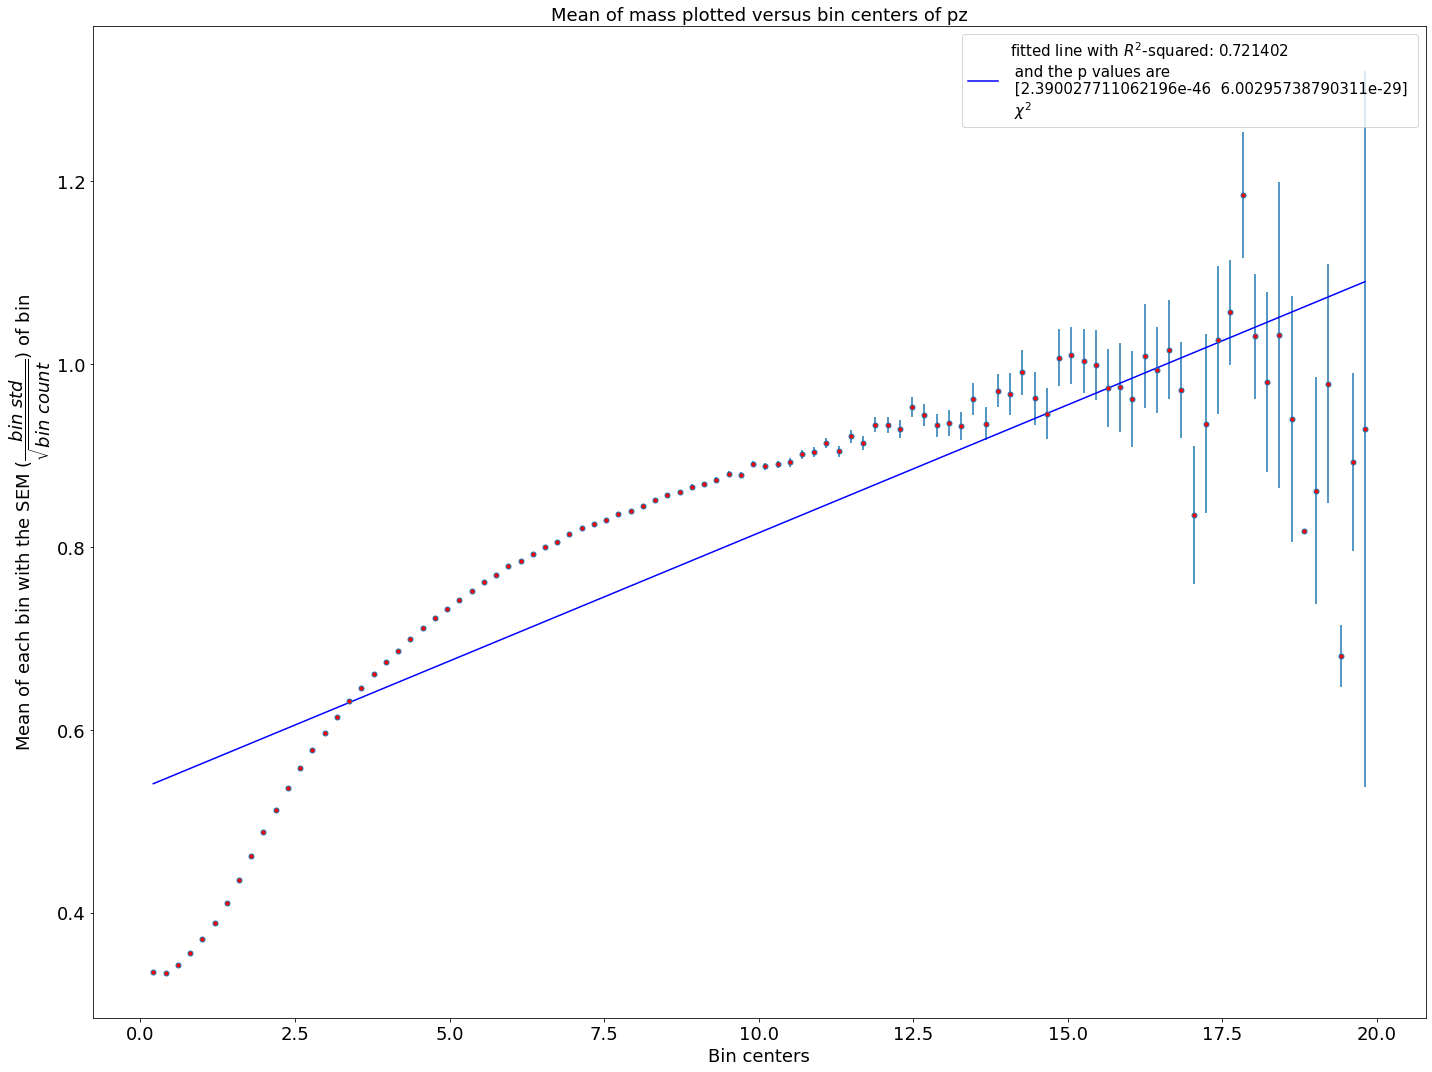

In [26]:
profile_plot(background,'pz','mass',uniform_binning)

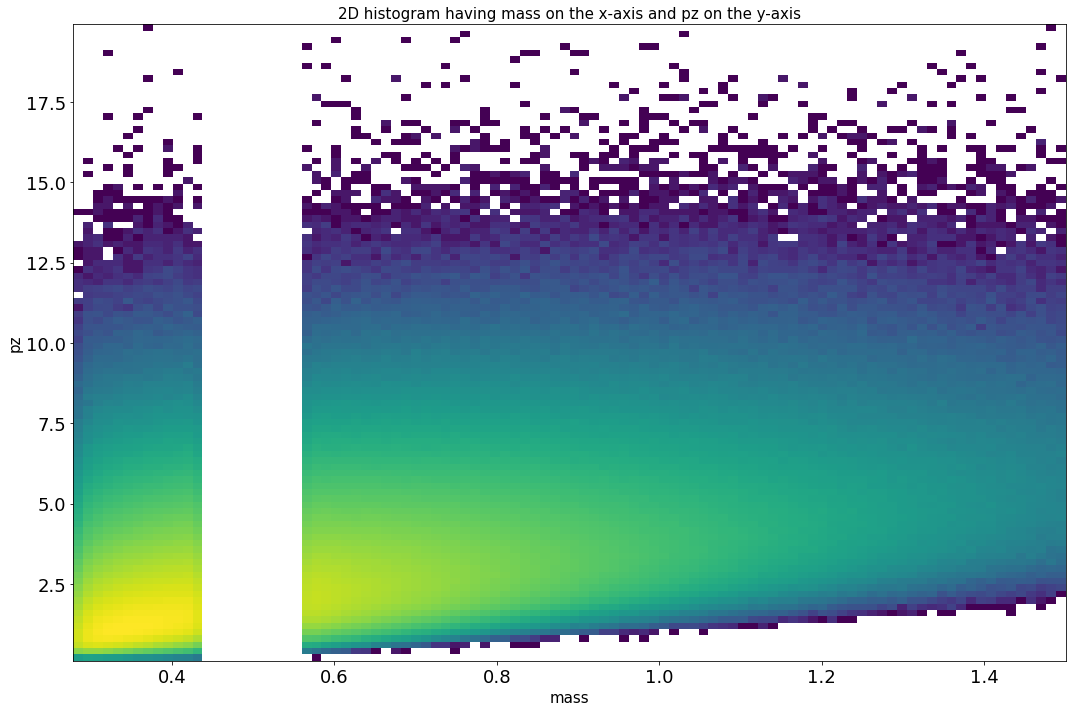

In [27]:
two_D_hist(background['mass'], background['pz'])

Correlations for pT

summary()
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     334.5
Date:                Wed, 04 Aug 2021   Prob (F-statistic):           2.33e-33
Time:                        17:00:20   Log-Likelihood:                 123.77
No. Observations:                 100   AIC:                            -243.5
Df Residuals:                      98   BIC:                            -238.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5099      0.014     35.9

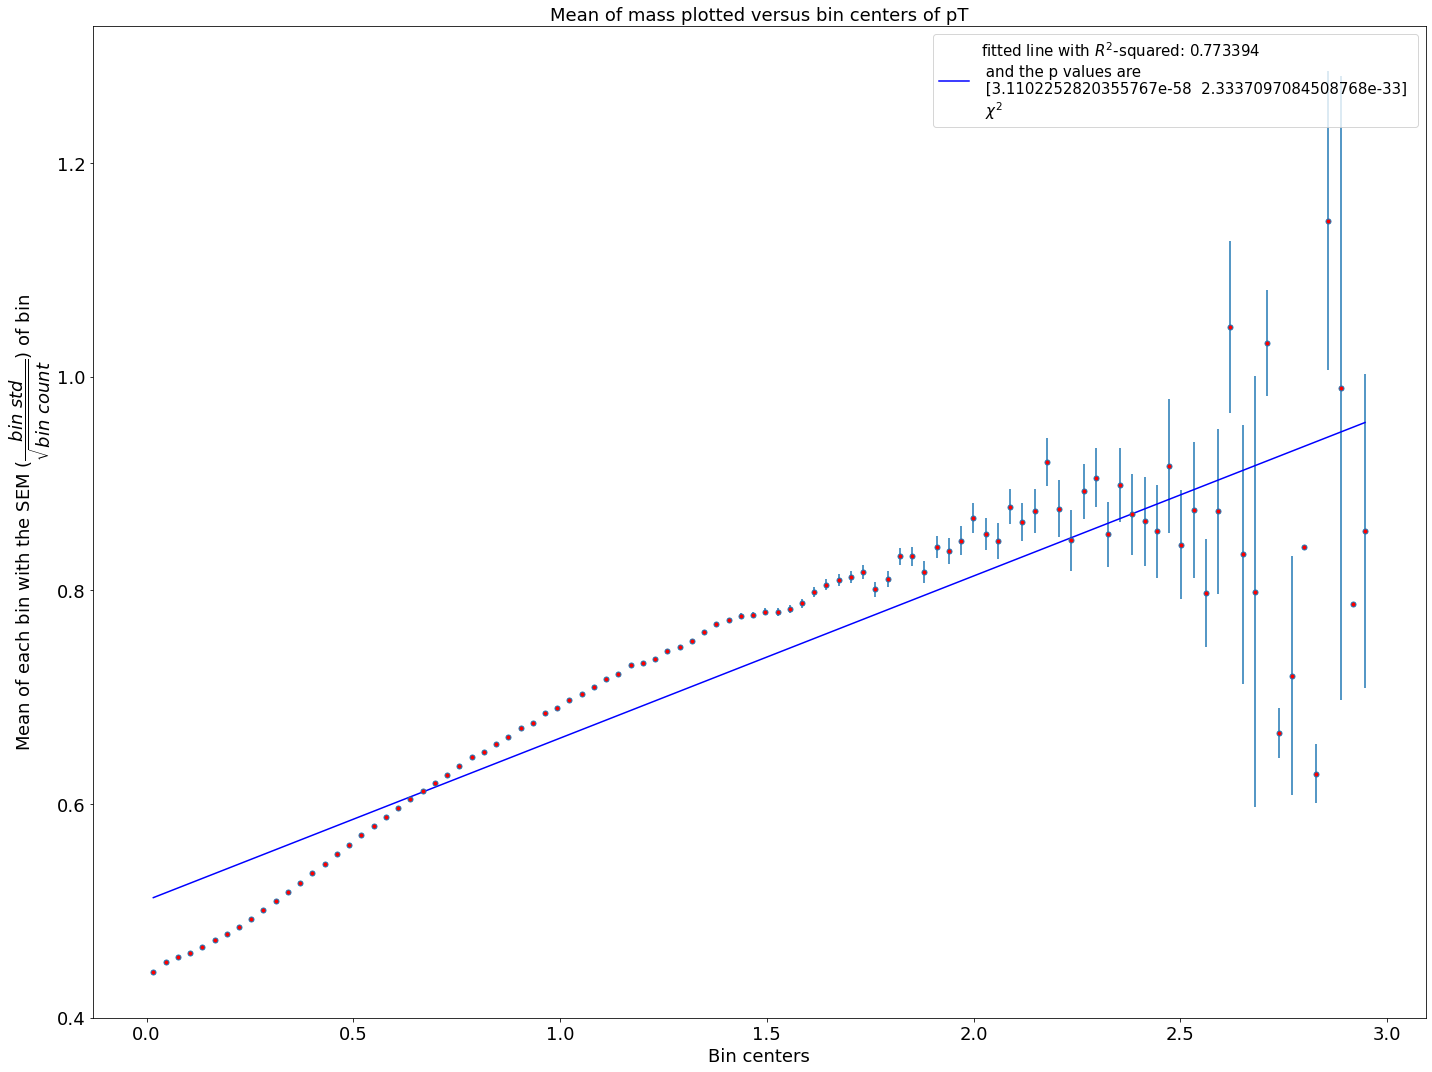

In [28]:
profile_plot(background,'pT','mass',uniform_binning)

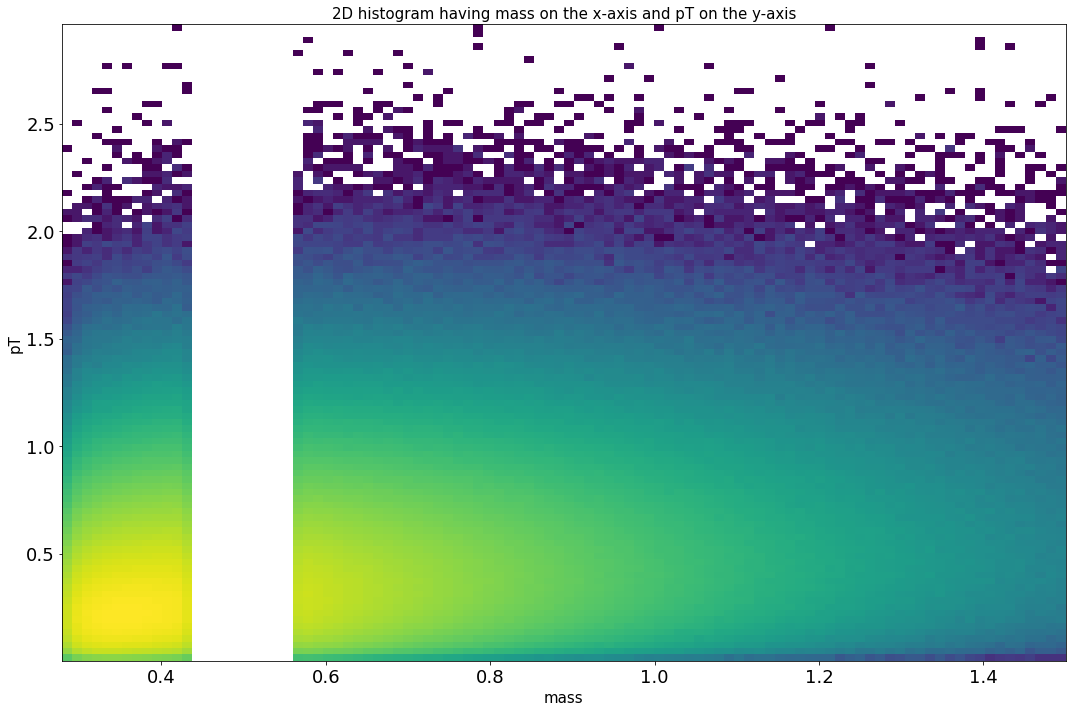

In [29]:
two_D_hist(background['mass'], background['pT'])

Correlations for cosinefirst

summary()
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 04 Aug 2021   Prob (F-statistic):                nan
Time:                        17:00:33   Log-Likelihood:                    nan
No. Observations:                 100   AIC:                               nan
Df Residuals:                      98   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        n

<ipython-input-20-d4ddfe1d838f>:9: RuntimeWarning: invalid value encountered in true_divide
  plt.errorbar(x=bin_centers, y=bin_means, yerr=(bin_std/np.sqrt(bin_count)), linestyle='none', marker='.',mfc='red', ms=10)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

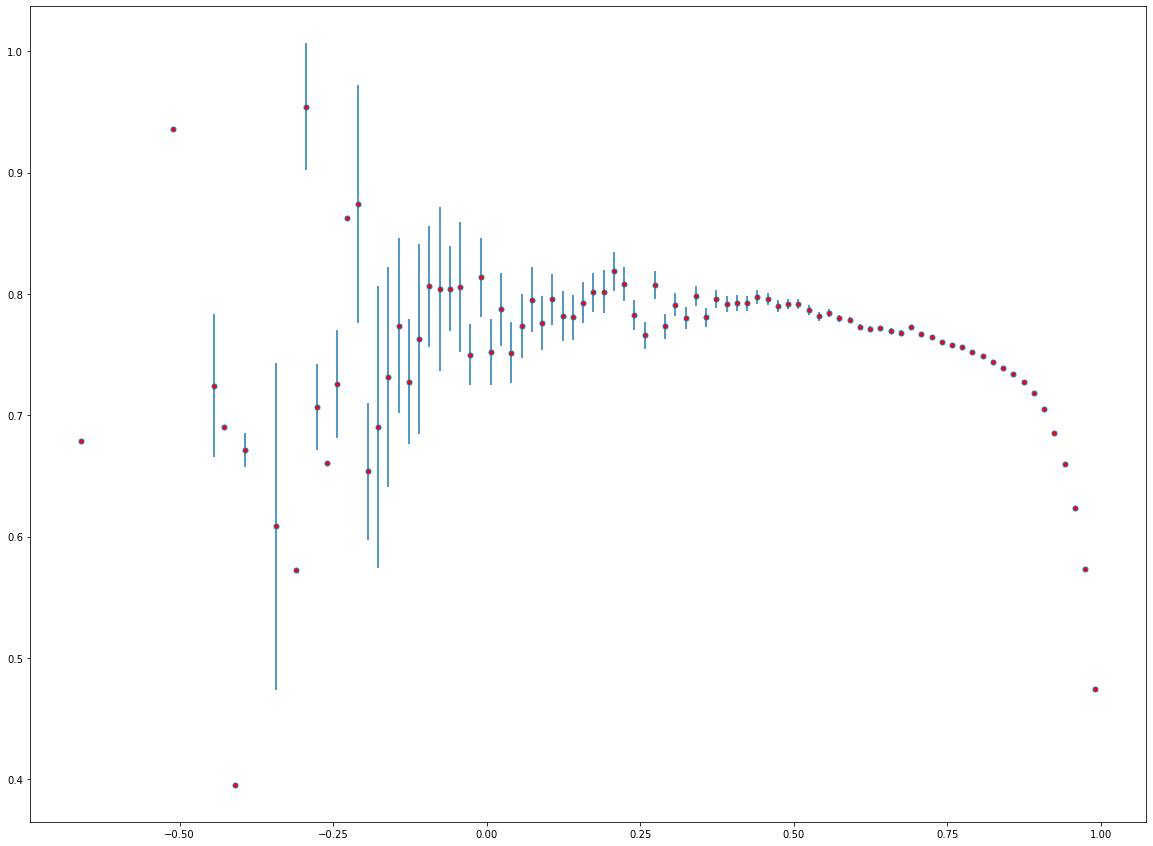

In [30]:
profile_plot(background,'cosinefirst','mass',uniform_binning)

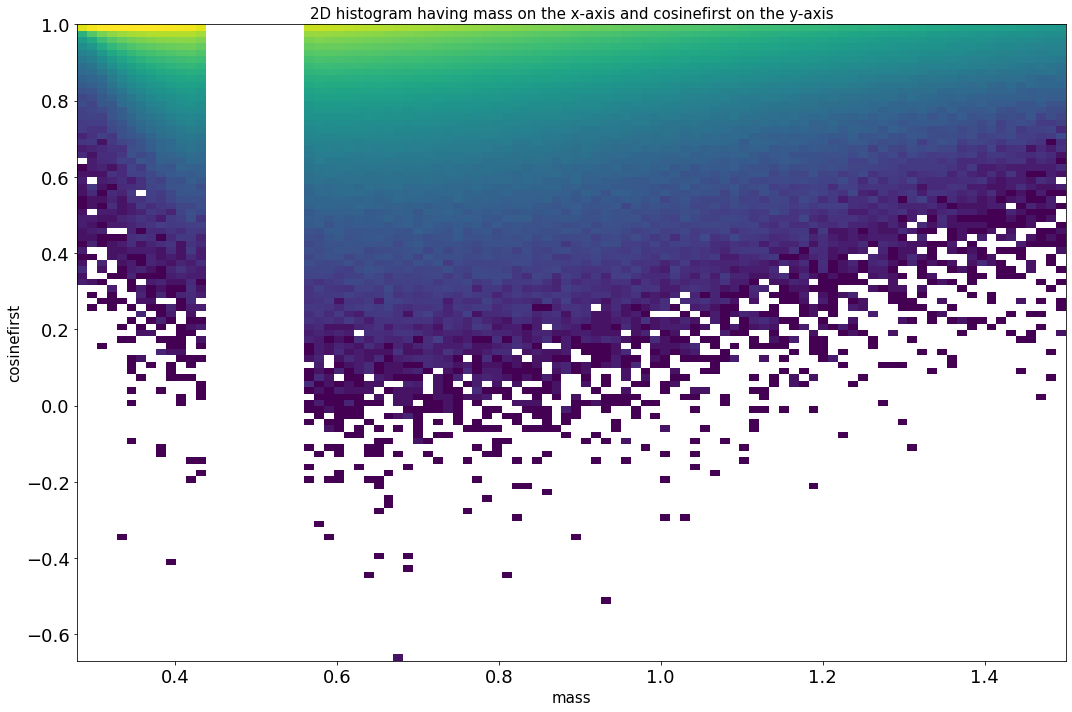

In [31]:
two_D_hist(background['mass'], background['cosinefirst'])

Correlations for cosinesecond

summary()
                             OLS Regression Results                            
Dep. Variable:                      y   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 04 Aug 2021   Prob (F-statistic):                nan
Time:                        17:01:08   Log-Likelihood:                    nan
No. Observations:                 100   AIC:                               nan
Df Residuals:                      98   BIC:                               nan
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        n

<ipython-input-20-d4ddfe1d838f>:9: RuntimeWarning: invalid value encountered in true_divide
  plt.errorbar(x=bin_centers, y=bin_means, yerr=(bin_std/np.sqrt(bin_count)), linestyle='none', marker='.',mfc='red', ms=10)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

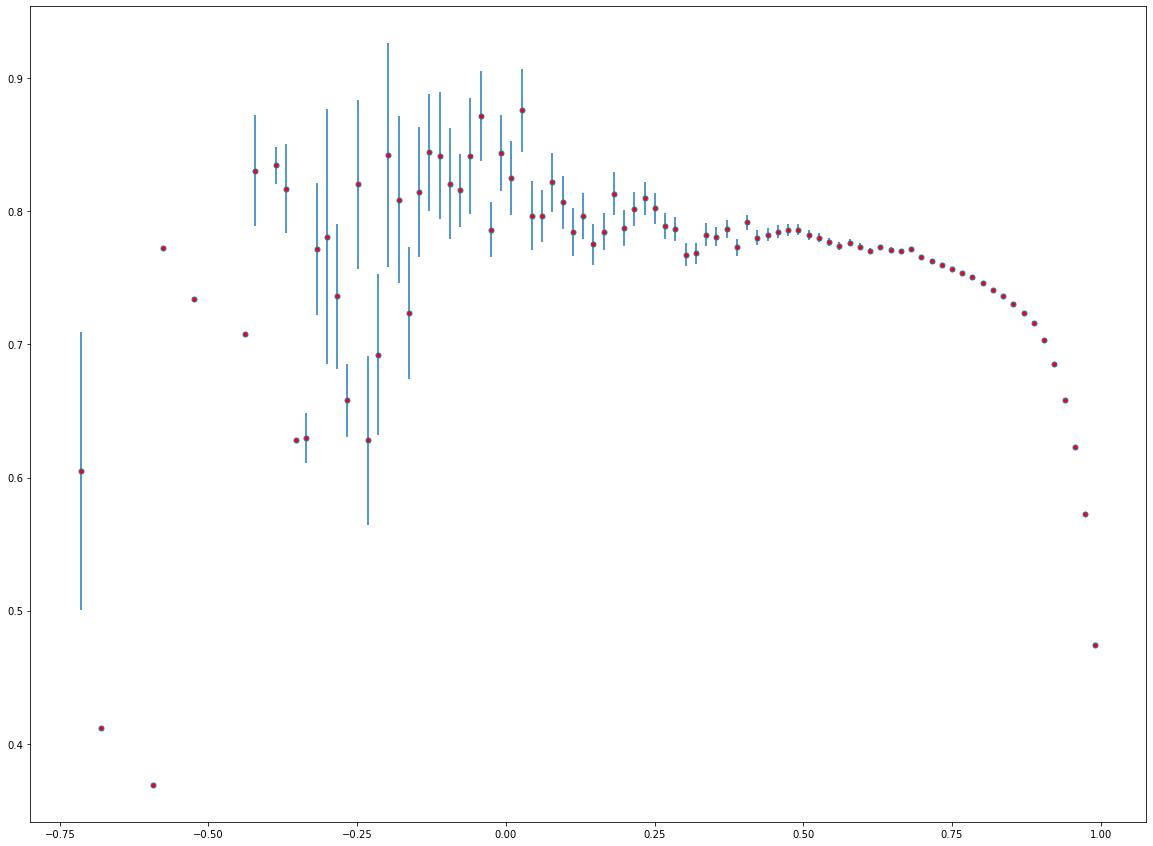

In [33]:
profile_plot(background,'cosinesecond','mass',uniform_binning)

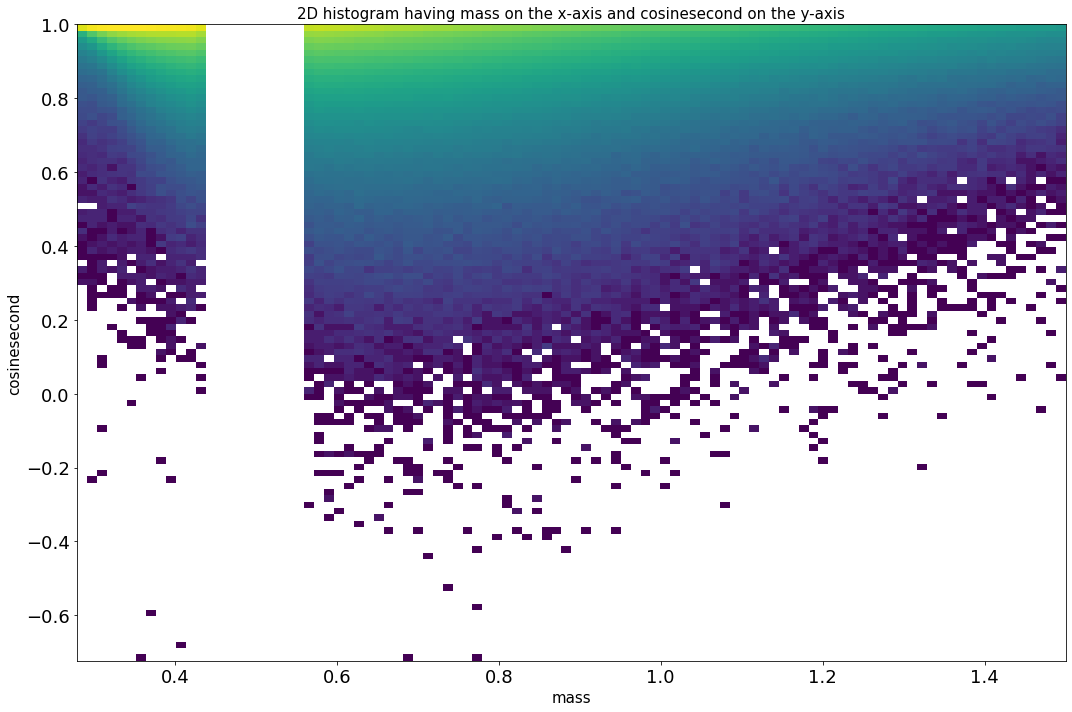

In [32]:
two_D_hist(background['mass'], background['cosinesecond'])